In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools

# enumerate
S, I, R = 0, 1, 2

In [2]:
# initialize state of nodes in the graph
def initialize_random_state(num_initial_infected, n_nodes):
  random_state = [I if i < num_initial_infected else S for i in range(n_nodes)]
  random.shuffle(random_state) # randomize who is infected
  return random_state

def update_node_states(G, states):
  for i, node in G.nodes.items():
    node["state"] = states[i]

def discrete_time_SIR(G, next_node_states, time_steps, beta, rho):
  ## initial condition
  # plot_graph(G, title="Graph $\mathcal{G}$, t=0") # plot initial state
  newly_infected_in_time = np.zeros(time_steps)
  population_in_time = {'S': np.zeros(time_steps+1),
                        'I':    np.zeros(time_steps+1),
                        'R':   np.zeros(time_steps+1)}
  population_in_time['I'][0] = np.sum([next_node_states[i] == I for i in range(len(next_node_states))])
  population_in_time['S'][0] = len(next_node_states) - population_in_time['I'][0]
  population_in_time['R'][0] = 0
  absorbing_state = False # used to stop iterations if reached

  #the dynamics start
  for t in range(time_steps):
    if not absorbing_state:
      for node_i, node_attr in G.nodes().items():
        if node_attr["state"]==S:
          # calculate probability of infection
          infected_neighbours = np.sum([G.nodes[node_j]["state"]==I for node_j in G.neighbors(node_i)])
          probability_of_infection = 1 - (1 - beta)**infected_neighbours

          # simulate random behaviour
          u = np.random.uniform()
          next_node_states[node_i] = I if u < probability_of_infection else S
          newly_infected_in_time[t] += 1 if u < probability_of_infection else 0

        elif node_attr["state"]==I:
          # probability_of_recovery = rho
          # simulate random behaviour
          u = np.random.uniform()
          next_node_states[node_i] = R if u < rho else I
      # check if reached absorving state
      total_infected_next_step = sum([state == I for state in next_node_states])
      population_in_time['S'][t+1] = sum([next_node_states[i] == S for i in range(len(next_node_states))])
      population_in_time['I'][t+1] = sum([next_node_states[i] == I for i in range(len(next_node_states))])
      population_in_time['R'][t+1] = sum([next_node_states[i] == R for i in range(len(next_node_states))])
      absorbing_state = total_infected_next_step == 0

      # update and plot current state
      update_node_states(G, next_node_states)
      # plot_graph(G, title = f"t={t+1}")

    else: # reached absorbing state so propagate final state in time
      for status, vector_in_time in population_in_time.items():
        vector_in_time[t+1] = vector_in_time[t]

  return newly_infected_in_time, population_in_time

In [3]:
n_nodes = 500
# Graph generation
G = nx.cycle_graph(n_nodes)
for n in range(n_nodes):
    G.add_edge(n,(n+2) % n_nodes)
    G.add_edge(n,(n-2) % n_nodes)


n_infected = 10
n_simulations = 100
n_weeks = 15
newly_infected = []
population = []
for simulation in range(n_simulations):
  # reset random status
  next_node_states = initialize_random_state(n_infected, n_nodes) # first infected in the network
  update_node_states(G, next_node_states)

  # simulate
  newly_infected_in_time, population_in_time = discrete_time_SIR(G, next_node_states, time_steps=n_weeks, beta=0.3, rho=0.7)

  # save results
  newly_infected.append(newly_infected_in_time)
  population.append(population_in_time)

# compute average results
avg_newly_infected_per_week = []
avg_S_per_week = []
avg_I_per_week = []
avg_R_per_week = []
for week in range(n_weeks):
  avg_newly_infected_per_week.append(np.mean([newly_infected[sim][week] for sim in range(n_simulations)]))
for week in range(n_weeks+1):
  avg_S_per_week.append(np.mean([pop['S'][week] for pop in population]))
  avg_I_per_week.append(np.mean([pop['I'][week] for pop in population]))
  avg_R_per_week.append(np.mean([pop['R'][week] for pop in population]))

print(f"avg newly infected per week: {avg_newly_infected_per_week}")
print(f"avg S per week: {avg_S_per_week}")
print(f"avg I per week: {avg_I_per_week}")
print(f"avg R per week: {avg_R_per_week}")

# plot graph
def plot_graph(G, title="Graph $\mathcal{G}$"):
  # S = green, I = red, R = blue
  colors = ["tab:red" if n["state"]==I else "tab:green" if n["state"]==S else "tab:blue" for _, n in G.nodes().items()]
  pos = nx.circular_layout(G)
  fig, ax = plt.subplots(figsize=(4,4))
  plt.title(title)
  nx.draw(G,pos,with_labels=True, node_color=colors)

# plot_graph(G)

avg newly infected per week: [11.71, 10.39, 8.09, 5.59, 3.63, 2.63, 1.9, 1.33, 0.9, 0.69, 0.47, 0.31, 0.21, 0.16, 0.11]
avg S per week: [490.0, 478.29, 467.9, 459.81, 454.22, 450.59, 447.96, 446.06, 444.73, 443.83, 443.14, 442.67, 442.36, 442.15, 441.99, 441.88]
avg I per week: [10.0, 14.72, 14.82, 12.54, 9.24, 6.39, 4.54, 3.18, 2.45, 1.62, 1.23, 0.75, 0.5, 0.38, 0.25, 0.2]
avg R per week: [0.0, 6.99, 17.28, 27.65, 36.54, 43.02, 47.5, 50.76, 52.82, 54.55, 55.63, 56.58, 57.14, 57.47, 57.76, 57.92]


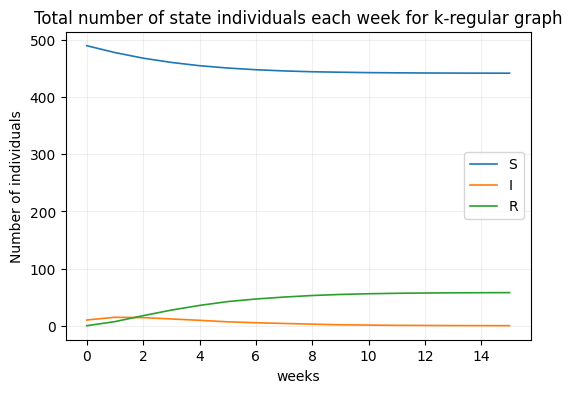

In [ ]:
# plot results
fig, ax = plt.subplots(figsize=(6,4))
avg_population = []
avg_population.append(avg_S_per_week)
avg_population.append(avg_I_per_week)
avg_population.append(avg_R_per_week)
lab = ["S","I","R"]
for i in range(len(avg_population)):
  plt.plot(np.arange(0,n_weeks + 1,1), avg_population[i],label=lab[i], linewidth=1.2)
plt.legend()
plt.title("Total number of state individuals each week for k-regular graph")
plt.xlabel("weeks")
plt.ylabel("Number of individuals")
plt.grid('minor', alpha=0.2)
fig.savefig('ex1_total_individuals.svg', format='svg', dpi=1200)
plt.show()

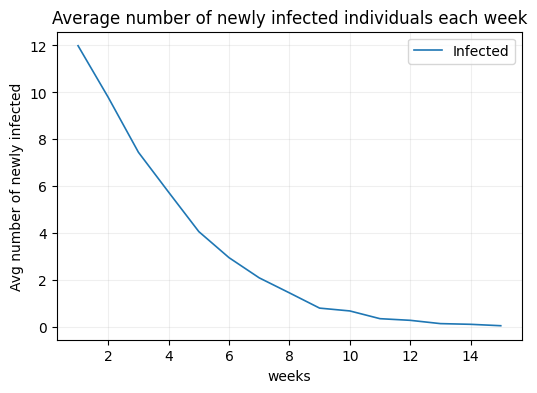

In [ ]:
# plot results
fig, ax = plt.subplots(figsize=(6,4))
plt.plot(np.arange(1,n_weeks + 1,1), avg_newly_infected_per_week,label="Infected", linewidth=1.2)
plt.legend()
plt.title("Average number of newly infected individuals each week")
plt.xlabel("weeks")
plt.ylabel("Avg number of newly infected")
plt.grid('minor', alpha=0.2)
fig.savefig('ex1_avg_infected.svg', format='svg', dpi=1200)
plt.show()

-----------------------------------------------

# Problem 1_2

In [4]:
def GeneratePreferentialGraph(k,n_nodes):
  # k is the average degree that my network have at the end of generation
  GPA = nx.complete_graph(k+1) # my first graph is a complete graph with k + 1 nodes
  for node in range(k+2,n_nodes):
    degPA = [d for n, d in GPA.degree()]
    degPA = np.array(degPA)
    degPA = degPA / np.sum(degPA)
    if(node % 2 == 0):
      c = int(k/2)
    else:
      c = int((k + 1)/ 2)
    neighbors = np.random.choice(np.arange(len(GPA)), p=degPA, size=c, replace=False)
    GPA.add_node(node)
    for neigh in neighbors:
      GPA.add_edge(node,neigh)
  return GPA

In [5]:
k = 6
n_nodes = 500
G = GeneratePreferentialGraph(k,n_nodes)
degPA = [d for n, d in G.degree()]
print(np.mean(degPA))

5.988


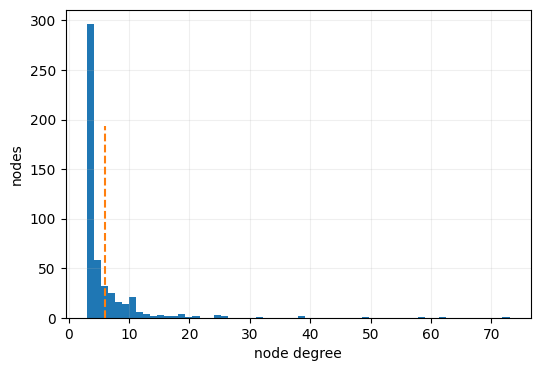

In [6]:
degPA
fig, ax = plt.subplots(figsize=(6,4))
plt.hist(degPA, bins = 60)
plt.ylabel("nodes")
plt.xlabel("node degree")
plt.vlines(np.mean(degPA),0, 193, colors="tab:orange", linestyles="dashed")
plt.grid('minor', alpha=0.2)
fig.savefig('prob1_preferential_histo.svg', format='svg', dpi=1200)
plt.show()

# Problem 2

In [7]:
def GeneratePreferentialGraph(k,n_nodes):
  # k is the average degree that my network have at the end of generation
  GPA = nx.complete_graph(k+1) # my first graph is a complete graph with k + 1 nodes
  for node in range(k+2,n_nodes):
    degPA = [d for n, d in GPA.degree()]
    degPA = np.array(degPA)
    degPA = degPA / np.sum(degPA)
    if(node % 2 == 0):
      c = int(k/2)
    else:
      c = int((k + 1)/ 2)
    neighbors = np.random.choice(np.arange(len(GPA)), p=degPA, size=c, replace=False)
    GPA.add_node(node)
    for neigh in neighbors:
      GPA.add_edge(node,neigh)
  return GPA

def discrete_time_SIR(G, next_node_states, time_steps, beta, rho):
  ## initial condition
  # plot_graph(G, title="Graph $\mathcal{G}$, t=0") # plot initial state
  newly_infected_in_time = np.zeros(time_steps)
  population_in_time = {'S': np.zeros(time_steps+1),
                        'I':    np.zeros(time_steps+1),
                        'R':   np.zeros(time_steps+1)}
  population_in_time['I'][0] = np.sum([next_node_states[i] == I for i in range(len(next_node_states))])
  population_in_time['S'][0] = len(next_node_states) - population_in_time['I'][0]
  population_in_time['R'][0] = 0
  absorbing_state = False # used to stop iterations if reached

  #the dynamics start
  for t in range(time_steps):
    if not absorbing_state:
      for node_i, node_attr in G.nodes().items():
        if node_attr["state"]==S:
          # calculate probability of infection
          infected_neighbours = np.sum([G.nodes[node_j]["state"]==I for node_j in G.neighbors(node_i)])
          probability_of_infection = 1 - (1 - beta)**infected_neighbours

          # simulate random behaviour
          u = np.random.uniform()
          next_node_states[node_i] = I if u < probability_of_infection else S
          newly_infected_in_time[t] += 1 if u < probability_of_infection else 0

        elif node_attr["state"]==I:
          # probability_of_recovery = rho
          # simulate random behaviour
          u = np.random.uniform()
          next_node_states[node_i] = R if u < rho else I
      # check if reached absorving state
      total_infected_next_step = sum([state == I for state in next_node_states])
      population_in_time['S'][t+1] = sum([next_node_states[i] == S for i in range(len(next_node_states))])
      population_in_time['I'][t+1] = sum([next_node_states[i] == I for i in range(len(next_node_states))])
      population_in_time['R'][t+1] = sum([next_node_states[i] == R for i in range(len(next_node_states))])
      absorbing_state = total_infected_next_step == 0

      # update and plot current state
      update_node_states(G, next_node_states)
      # plot_graph(G, title = f"t={t+1}")

    else: # reached absorbing state so propagate final state in time
      for status, vector_in_time in population_in_time.items():
        vector_in_time[t+1] = vector_in_time[t]

  return newly_infected_in_time, population_in_time

# initialize state of nodes in the graph
def initialize_random_state(num_initial_infected, n_nodes):
  random_state = [I if i < num_initial_infected else S for i in range(n_nodes)]
  random.shuffle(random_state) # randomize who is infected
  return random_state

def update_node_states(G, states):
  for i, node in G.nodes.items():
    node["state"] = states[i]


In [8]:
k = 6
n_nodes = 500
G = GeneratePreferentialGraph(k,n_nodes)


n_infected = 10
n_simulations = 100
n_weeks = 15
newly_infected = []
population = []
for simulation in range(n_simulations):
  # reset random status
  next_node_states = initialize_random_state(n_infected, n_nodes)
  update_node_states(G, next_node_states)

  # simulate
  newly_infected_in_time, population_in_time = discrete_time_SIR(G, next_node_states, time_steps=n_weeks, beta=0.3, rho=0.7)

  # save results
  newly_infected.append(newly_infected_in_time)
  population.append(population_in_time)

# compute average results
avg_newly_infected_per_week = []
avg_S_per_week = []
avg_I_per_week = []
avg_R_per_week = []
for week in range(n_weeks):
  avg_newly_infected_per_week.append(np.mean([newly_infected[sim][week] for sim in range(n_simulations)]))
for week in range(n_weeks+1):
  avg_S_per_week.append(np.mean([pop['S'][week] for pop in population]))
  avg_I_per_week.append(np.mean([pop['I'][week] for pop in population]))
  avg_R_per_week.append(np.mean([pop['R'][week] for pop in population]))

print(f"avg newly infected per week: {avg_newly_infected_per_week}")
print(f"avg S per week: {avg_S_per_week}")
print(f"avg I per week: {avg_I_per_week}")
print(f"avg R per week: {avg_R_per_week}")


avg newly infected per week: [18.08, 56.39, 101.22, 102.91, 66.12, 30.96, 13.59, 6.28, 2.7, 1.03, 0.56, 0.33, 0.12, 0.05, 0.03]
avg S per week: [490.0, 471.92, 415.53, 314.31, 211.4, 145.28, 114.32, 100.73, 94.45, 91.75, 90.72, 90.16, 89.83, 89.71, 89.66, 89.63]
avg I per week: [10.0, 21.16, 62.51, 120.45, 138.97, 107.85, 63.06, 32.71, 16.21, 7.38, 3.29, 1.44, 0.68, 0.34, 0.17, 0.08]
avg R per week: [0.0, 6.92, 21.96, 65.24, 149.63, 246.87, 322.62, 366.56, 389.34, 400.87, 405.99, 408.4, 409.49, 409.95, 410.17, 410.29]


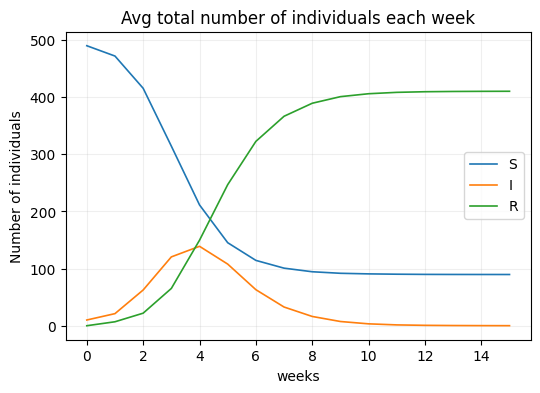

In [9]:
# plot results
fig, ax = plt.subplots(figsize=(6,4))
avg_population = []
avg_population.append(avg_S_per_week)
avg_population.append(avg_I_per_week)
avg_population.append(avg_R_per_week)
lab = ["S","I","R"]
for i in range(len(avg_population)):
  plt.plot(np.arange(0,n_weeks + 1,1), avg_population[i],label=lab[i], linewidth=1.2)
plt.legend()
plt.title("Avg total number of individuals each week")
plt.xlabel("weeks")
plt.ylabel("Number of individuals")
plt.grid('minor', alpha=0.2)
fig.savefig('prob2_total_individuals.svg', format='svg', dpi=1200)
plt.show()

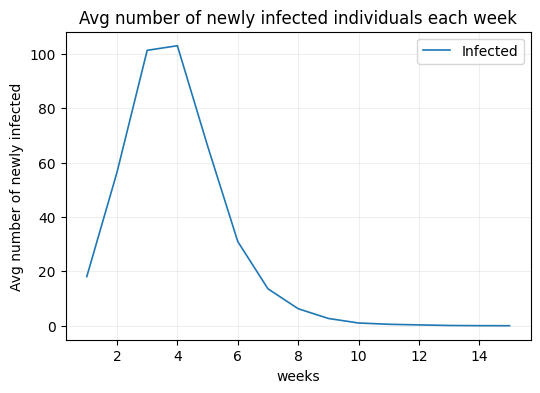

In [10]:
# plot results
fig, ax = plt.subplots(figsize=(6,4))
plt.plot(np.arange(1,n_weeks + 1,1), avg_newly_infected_per_week,label="Infected", linewidth=1.2)
plt.legend()
plt.title("Avg number of newly infected individuals each week")
plt.xlabel("weeks")
plt.ylabel("Avg number of newly infected")
plt.grid('minor', alpha=0.2)
fig.savefig('prob2_avg_infected.svg', format='svg', dpi=1200)
plt.show()

# Problem 3

------------------------------

In [11]:
def GeneratePreferentialGraph(k,n_nodes):
  # k is the average degree that my network have at the end of generation
  GPA = nx.complete_graph(k+1) # my first graph is a complete graph with k + 1 nodes
  for node in range(k+2,n_nodes):
    degPA = [d for n, d in GPA.degree()]
    degPA = np.array(degPA)
    degPA = degPA / np.sum(degPA)
    if(node % 2 == 0):
      c = int(k/2)
    else:
      c = int((k + 1)/ 2)
    neighbors = np.random.choice(np.arange(len(GPA)), p=degPA, size=c, replace=False)
    GPA.add_node(node)
    for neigh in neighbors:
      GPA.add_edge(node,neigh)
  return GPA


def update_node_states(G, states):
  for i, node in G.nodes.items():
    node["state"] = states[i]

def update_node_vaccinated(G, perc, vaccinated_index):
  result = [element for element in np.arange(len(G)) if element not in vaccinated_index]

  tmp = np.random.choice(result, size = round(perc*len(G)), replace = False)
  vaccinated_index.extend(tmp)
  for el in tmp: # G.nodes()[vaccinated_index] is not hashable
    G.nodes()[el]["vaccinated"] = True

# initialize state of nodes in the graph
def initialize_random_state(num_initial_infected, n_nodes):
  random_state = [I if i < num_initial_infected else S for i in range(n_nodes)]
  random.shuffle(random_state) # randomize who is infected
  return random_state

def discrete_time_SIR_vaccinated(G, next_node_states, time_steps, beta, rho):
  ## initial condition
  # plot_graph(G, title="Graph $\mathcal{G}$, t=0") # plot initial state
  newly_infected_in_time = np.zeros(time_steps)
  population_in_time = {'S': np.zeros(time_steps+1),
                        'I':    np.zeros(time_steps+1),
                        'R':   np.zeros(time_steps+1),
                        'V': np.zeros(time_steps+1)}
  population_in_time['I'][0] = np.sum([next_node_states[i] == I for i in range(len(next_node_states))])
  population_in_time['S'][0] = len(next_node_states) - population_in_time['I'][0]
  population_in_time['R'][0] = 0
  population_in_time['V'][0] = 0
  absorbing_state = False # used to stop iterations if reached
  vaccinated = [0, 0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.60, 0.60, 0.60, 0.60, 0.60, 0.60, 0.60, 0.60]
  vaccinated_index = []
  for i, node in G.nodes().items():
    node["vaccinated"] = False

  #the dynamics start
  for t in range(time_steps):
    if(t>0):
      update_node_vaccinated(G,vaccinated[t]-vaccinated[t-1],vaccinated_index) # posso vaccinarmi pure se son giunto ad un absorbing state alla settimana 4 ad esempio, il che cambia il numero di susceptabile nelle statistiche dopo

    if not absorbing_state:
      for node_i, node_attr in G.nodes().items():
        if node_attr["state"]==S and not node_attr["vaccinated"]:
          # calculate probability of infection
          infected_neighbours = np.sum([(G.nodes[node_j]["state"]==I and not G.nodes[node_j]["vaccinated"]) for node_j in G.neighbors(node_i)])
          probability_of_infection = 1 - (1 - beta)**infected_neighbours

          # simulate random behaviour
          u = np.random.uniform()
          next_node_states[node_i] = I if u < probability_of_infection else S
          newly_infected_in_time[t] += 1 if u < probability_of_infection else 0

        elif node_attr["state"]==I:
          # probability_of_recovery = rho
          # simulate random behaviour
          u = np.random.uniform()
          next_node_states[node_i] = R if u < rho else I
      # check if reached absorving state
      total_infected_next_step = sum([state == I for state in next_node_states])

      population_in_time['S'][t+1] = sum([next_node_states[i] == S for i in range(len(next_node_states))])
      population_in_time['I'][t+1] = sum([next_node_states[i] == I for i in range(len(next_node_states))])
      population_in_time['R'][t+1] = sum([next_node_states[i] == R for i in range(len(next_node_states))])
      population_in_time['V'][t+1] = sum([G.nodes()[i]['vaccinated'] for i in range(len(G))])
      absorbing_state = total_infected_next_step == 0

      # update and plot current state
      update_node_states(G, next_node_states)
      # plot_graph(G, title = f"t={t+1}")

    else: # reached absorbing state so propagate final state in time
      for status, vector_in_time in population_in_time.items():
        vector_in_time[t+1] = vector_in_time[t]

  return newly_infected_in_time, population_in_time


In [12]:
k = 6
n_nodes = 500
G = GeneratePreferentialGraph(k,n_nodes)


n_infected = 10
n_simulations = 100
n_weeks = 15
newly_infected = []
population = []
for simulation in range(n_simulations):
  # reset random status
  next_node_states = initialize_random_state(n_infected, n_nodes)
  update_node_states(G, next_node_states)

  # simulate
  newly_infected_in_time, population_in_time = discrete_time_SIR_vaccinated(G, next_node_states, time_steps=n_weeks, beta=0.3, rho=0.7)

  # save results
  newly_infected.append(newly_infected_in_time)
  population.append(population_in_time)

# compute average results
avg_newly_infected_per_week = []
avg_newly_vaccinated_per_week = []
avg_S_per_week = []
avg_I_per_week = []
avg_R_per_week = []
avg_V_per_week = []
for week in range(n_weeks):
  avg_newly_infected_per_week.append(np.mean([newly_infected[sim][week] for sim in range(n_simulations)]))

for week in range(n_weeks+1):
  avg_S_per_week.append(np.mean([pop['S'][week] for pop in population]))
  avg_I_per_week.append(np.mean([pop['I'][week] for pop in population]))
  avg_R_per_week.append(np.mean([pop['R'][week] for pop in population]))
  avg_V_per_week.append(np.mean([pop['V'][week] for pop in population]))
for week in range(n_weeks):
  avg_newly_vaccinated_per_week.append(avg_V_per_week[week+1] - avg_V_per_week[week])
print(f"avg newly infected per week: {avg_newly_infected_per_week}")
print(f"avg newly vaccinated per week: {avg_newly_vaccinated_per_week}")
print(f"avg S per week: {avg_S_per_week}")
print(f"avg I per week: {avg_I_per_week}")
print(f"avg R per week: {avg_R_per_week}")
print(f"avg V per week: {avg_V_per_week}")

avg newly infected per week: [17.03, 47.34, 71.3, 57.32, 28.91, 11.53, 4.19, 1.23, 0.59, 0.21, 0.11, 0.06, 0.01, 0.0, 0.0]
avg newly vaccinated per week: [0.0, 25.0, 50.0, 50.0, 50.0, 50.0, 50.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
avg S per week: [490.0, 472.97, 425.63, 354.33, 297.01, 268.1, 256.57, 252.38, 251.15, 250.56, 250.35, 250.24, 250.18, 250.17, 250.17, 250.17]
avg I per week: [10.0, 19.87, 53.6, 87.56, 84.19, 54.67, 28.07, 12.74, 4.94, 2.06, 0.83, 0.38, 0.13, 0.05, 0.02, 0.0]
avg R per week: [0.0, 7.16, 20.77, 58.11, 118.8, 177.23, 215.36, 234.88, 243.91, 247.38, 248.82, 249.38, 249.69, 249.78, 249.81, 249.83]
avg V per week: [0.0, 0.0, 25.0, 75.0, 125.0, 175.0, 225.0, 275.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0, 300.0]


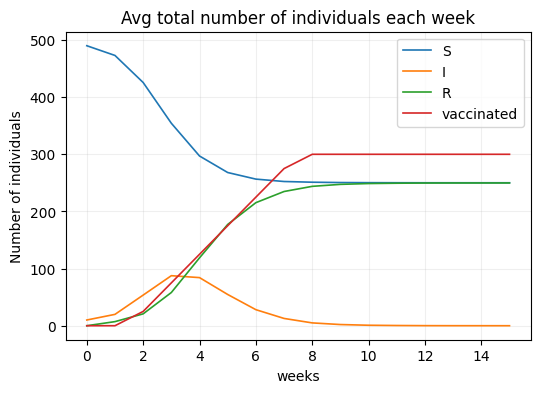

In [13]:
# plot results
fig, ax = plt.subplots(figsize=(6,4))
avg_population = []
avg_population.append(avg_S_per_week)
avg_population.append(avg_I_per_week)
avg_population.append(avg_R_per_week)
avg_population.append(avg_V_per_week)
lab = ["S","I","R","vaccinated"]
for i in range(len(avg_population)):
  plt.plot(np.arange(0,n_weeks + 1,1), avg_population[i],label=lab[i], linewidth=1.2)
plt.legend()
plt.title("Avg total number of individuals each week")
plt.xlabel("weeks")
plt.ylabel("Number of individuals")
plt.grid('minor', alpha=0.2)
fig.savefig('prob3_total_individuals.svg', format='svg', dpi=1200)
plt.show()

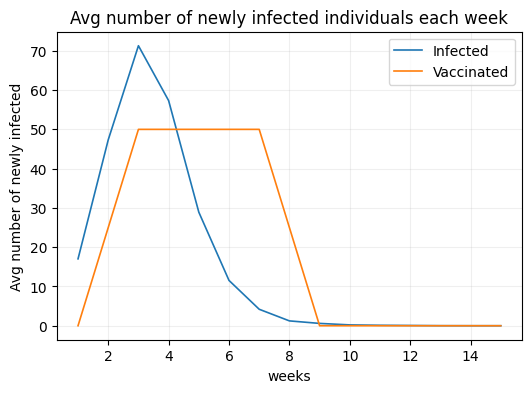

In [14]:
# plot results
fig, ax = plt.subplots(figsize=(6,4))
plt.plot(np.arange(1,n_weeks + 1,1), avg_newly_infected_per_week,label="Infected", linewidth=1.2)
plt.plot(np.arange(1,n_weeks + 1,1), avg_newly_vaccinated_per_week,label="Vaccinated", linewidth=1.2)
plt.legend()
plt.title("Avg number of newly infected individuals each week")
plt.xlabel("weeks")
plt.ylabel("Avg number of newly infected")
plt.grid('minor', alpha=0.2)
fig.savefig('prob3_avg_infected.svg', format='svg', dpi=1200)
plt.show()

# Problem 4

In [43]:
param_grid = {
    "k" : [7,8,9,10],
    "beta" : [0.2,0.3,0.4],
    "rho" : [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
}

In [17]:
param_grid = { #best parameters found
    "k" : [10],
    "beta" : [0.2],
    "rho" : [0.4],
}

In [44]:
def GeneratePreferentialGraph(k,n_nodes):
  # k is the average degree that my network have at the end of generation
  GPA = nx.complete_graph(k+1) # my first graph is a complete graph with k + 1 nodes
  for node in range(k+2,n_nodes):
    degPA = [d for n, d in GPA.degree()]
    degPA = np.array(degPA)
    degPA = degPA / np.sum(degPA)
    if(node % 2 == 0):
      c = int(k/2)
    else:
      c = int((k + 1)/ 2)
    neighbors = np.random.choice(np.arange(len(GPA)), p=degPA, size=c, replace=False)
    GPA.add_node(node)
    for neigh in neighbors:
      GPA.add_edge(node,neigh)
  return GPA

def update_node_states(G, states):
  for i, node in G.nodes.items():
    node["state"] = states[i]

def update_node_vaccinated(G, perc, vaccinated_index):
  result = [element for element in np.arange(len(G)) if element not in vaccinated_index]

  tmp = np.random.choice(result, size = round(perc*len(G)), replace = False)
  vaccinated_index.extend(tmp)
  for el in tmp: # G.nodes()[vaccinated_index] is not hashable
    G.nodes()[el]["vaccinated"] = True

# initialize state of nodes in the graph
def initialize_random_state(num_initial_infected, n_nodes):
  random_state = [I if i < num_initial_infected else S for i in range(n_nodes)]
  random.shuffle(random_state) # randomize who is infected
  return random_state

def discrete_time_SIR_vaccinated_SWEDEN(G, next_node_states, time_steps, beta, rho):
  ## initial condition
  # plot_graph(G, title="Graph $\mathcal{G}$, t=0") # plot initial state
  newly_infected_in_time = np.zeros(time_steps)
  population_in_time = {'S': np.zeros(time_steps+1),
                        'I':    np.zeros(time_steps+1),
                        'R':   np.zeros(time_steps+1),
                        'V': np.zeros(time_steps+1)}
  population_in_time['I'][0] = np.sum([next_node_states[i] == I for i in range(len(next_node_states))])
  population_in_time['S'][0] = len(next_node_states) - population_in_time['I'][0]
  population_in_time['R'][0] = 0

  for i, node in G.nodes().items():
    node["vaccinated"] = False
  vaccinated_index = []
  update_node_vaccinated(G,0.05,vaccinated_index)
  population_in_time['V'][0] = sum([G.nodes()[i]['vaccinated'] for i in range(len(G))])
  absorbing_state = False # used to stop iterations if reached
  vaccinated = [0.09, 0.16, 0.24, 0.32, 0.40, 0.47, 0.54, 0.59, 0.60, 0.60, 0.60, 0.60, 0.60, 0.60, 0.60, 0.60]



  #the dynamics start
  for t in range(time_steps):
    if(t == 0):
      update_node_vaccinated(G,vaccinated[t],vaccinated_index)
    if(t>0):
      update_node_vaccinated(G,vaccinated[t]-vaccinated[t-1],vaccinated_index) # posso vaccinarmi pure se son giunto ad un absorbing state alla settimana 4 ad esempio, il che cambia il numero di susceptabile nelle statistiche dopo

    if not absorbing_state:
      for node_i, node_attr in G.nodes().items():
        if node_attr["state"]==S and not node_attr["vaccinated"]:
          # calculate probability of infection
          infected_neighbours = np.sum([(G.nodes[node_j]["state"]==I and not G.nodes[node_j]["vaccinated"]) for node_j in G.neighbors(node_i)])
          probability_of_infection = 1 - (1 - beta)**infected_neighbours

          # simulate random behaviour
          u = np.random.uniform()
          next_node_states[node_i] = I if u < probability_of_infection else S
          newly_infected_in_time[t] += 1 if u < probability_of_infection else 0

        elif node_attr["state"]==I:
          # probability_of_recovery = rho
          # simulate random behaviour
          u = np.random.uniform()
          next_node_states[node_i] = R if u < rho else I
      # check if reached absorving state
      total_infected_next_step = sum([state == I for state in next_node_states])
      population_in_time['S'][t+1] = sum([next_node_states[i] == S for i in range(len(next_node_states))])
      population_in_time['I'][t+1] = sum([next_node_states[i] == I for i in range(len(next_node_states))])
      population_in_time['R'][t+1] = sum([next_node_states[i] == R for i in range(len(next_node_states))])
      population_in_time['V'][t+1] = sum([G.nodes()[i]['vaccinated'] for i in range(len(G))])
      absorbing_state = total_infected_next_step == 0

      # update and plot current state
      update_node_states(G, next_node_states)
      # plot_graph(G, title = f"t={t+1}")

    else: # reached absorbing state so propagate final state in time
      for status, vector_in_time in population_in_time.items():
        vector_in_time[t+1] = vector_in_time[t]

  return newly_infected_in_time, population_in_time
def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [46]:
best_rmse = 50 # high number
for params in itertools.product(*param_grid.values()):
  param_dict = dict(zip(param_grid.keys(), params))

  k = param_dict['k']
  n_nodes = 934
  G = GeneratePreferentialGraph(k,n_nodes)


  sweden_infected_per_week = [1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]

  rho = param_dict['rho']
  beta = param_dict['beta']
  n_infected = 1 # it's the first element in the I_o(t) in the assignment
  n_simulations = 100
  n_weeks = 15
  newly_infected = []
  population = []
  for simulation in range(n_simulations):
    # reset random status
    next_node_states = initialize_random_state(n_infected, n_nodes)
    update_node_states(G, next_node_states)

    # simulate
    newly_infected_in_time, population_in_time = discrete_time_SIR_vaccinated_SWEDEN(G, next_node_states, time_steps=n_weeks, beta=beta, rho=rho)

    # save results
    newly_infected.append(newly_infected_in_time)
    population.append(population_in_time)

  # compute average results
  avg_newly_infected_per_week = []
  avg_newly_vaccinated_per_week = []
  avg_S_per_week = []
  avg_I_per_week = []
  avg_R_per_week = []
  avg_V_per_week = []
  for week in range(n_weeks):
    avg_newly_infected_per_week.append(np.mean([newly_infected[sim][week] for sim in range(n_simulations)]))
  for week in range(n_weeks+1):
    avg_S_per_week.append(np.mean([pop['S'][week] for pop in population]))
    avg_I_per_week.append(np.mean([pop['I'][week] for pop in population]))
    avg_R_per_week.append(np.mean([pop['R'][week] for pop in population]))
    avg_V_per_week.append(np.mean([pop['V'][week] for pop in population]))
  for week in range(n_weeks):
    avg_newly_vaccinated_per_week.append(avg_V_per_week[week+1] - avg_V_per_week[week])
  rmse = RMSE(np.array(avg_newly_infected_per_week),np.array(sweden_infected_per_week))
  if(rmse < 10):
    print(f"RMSE {rmse} for parameters")
    print(param_dict, "\n")
  if rmse < best_rmse:
    best_rmse = rmse
    best_params = param_dict

RMSE 8.666854485144345 for parameters
{'k': 7, 'beta': 0.2, 'rho': 0.3} 

RMSE 8.537083030325212 for parameters
{'k': 7, 'beta': 0.2, 'rho': 0.4} 

RMSE 9.705857338054514 for parameters
{'k': 7, 'beta': 0.2, 'rho': 0.5} 

RMSE 9.25381434868887 for parameters
{'k': 7, 'beta': 0.2, 'rho': 0.6} 

RMSE 8.60550056649815 for parameters
{'k': 7, 'beta': 0.3, 'rho': 0.3} 

RMSE 7.190789942697534 for parameters
{'k': 7, 'beta': 0.3, 'rho': 0.4} 

RMSE 7.493889955601607 for parameters
{'k': 7, 'beta': 0.3, 'rho': 0.5} 

RMSE 7.745470073963663 for parameters
{'k': 7, 'beta': 0.3, 'rho': 0.6} 

RMSE 8.51917914668622 for parameters
{'k': 7, 'beta': 0.3, 'rho': 0.7} 

RMSE 8.597346489857593 for parameters
{'k': 7, 'beta': 0.3, 'rho': 0.8} 

RMSE 9.500181050906345 for parameters
{'k': 7, 'beta': 0.3, 'rho': 0.9} 

RMSE 9.271475970236166 for parameters
{'k': 7, 'beta': 0.3, 'rho': 1} 

RMSE 7.1101378327005715 for parameters
{'k': 8, 'beta': 0.2, 'rho': 0.3} 

RMSE 7.933888075842765 for parameters
{'k'

In [47]:
best_rmse

5.994709890117008

In [48]:
best_params

{'k': 9, 'beta': 0.2, 'rho': 0.3}

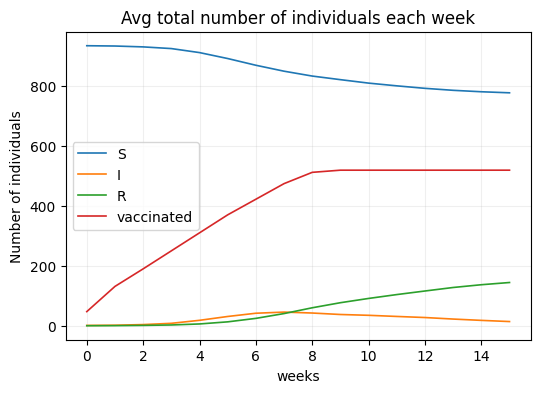

In [22]:
# plot results
fig, ax = plt.subplots(figsize=(6,4))
avg_population = []
avg_population.append(avg_S_per_week)
avg_population.append(avg_I_per_week)
avg_population.append(avg_R_per_week)
avg_population.append(avg_V_per_week)
lab = ["S","I","R","vaccinated"]
for i in range(len(avg_population)):
  plt.plot(np.arange(0,n_weeks + 1,1), avg_population[i],label=lab[i], linewidth=1.2)
plt.legend()
plt.title("Avg total number of individuals each week")
plt.xlabel("weeks")
plt.ylabel("Number of individuals")
plt.grid('minor', alpha=0.2)
fig.savefig('prob4_total_individuals.svg', format='svg', dpi=1200)
plt.show()

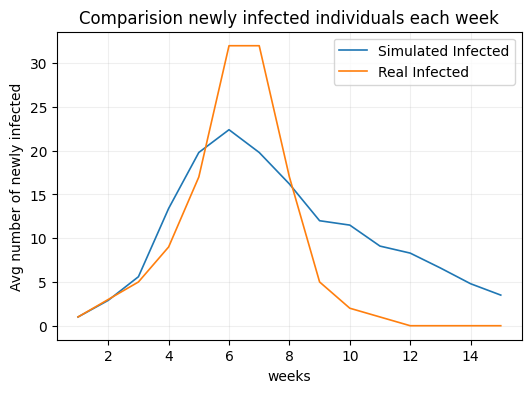

In [23]:
# plot results
fig, ax = plt.subplots(figsize=(6,4))
plt.plot(np.arange(1,n_weeks + 1,1), avg_newly_infected_per_week,label="Simulated Infected", linewidth=1.2)
plt.plot(np.arange(1,n_weeks + 1,1), sweden_infected_per_week,label="Real Infected", linewidth=1.2)
plt.legend()
plt.title("Comparision newly infected individuals each week")
plt.xlabel("weeks")
plt.ylabel("Avg number of newly infected")
plt.grid('minor', alpha=0.2)
fig.savefig('prob4_avg_infected.svg', format='svg', dpi=1200)
plt.show()

## Problem 4 with Strogatz Model (small-world)

In [49]:
param_grid = {
    "k" : [12,14,16],
    "p" : [0.4,0.5,0.6,0.7],
    "beta" : [0.2],
    "rho" : [0.5,0.6,0.7,0.8],
}

In [24]:
param_grid = {  #best parameters found
    "k" : [14],
    "p" : [0.7],
    "beta" : [0.2],
    "rho" : [0.8]
}

In [50]:
def update_node_states(G, states):
  for i, node in G.nodes.items():
    node["state"] = states[i]

def update_node_vaccinated(G, perc, vaccinated_index):
  result = [element for element in np.arange(len(G)) if element not in vaccinated_index]

  tmp = np.random.choice(result, size = round(perc*len(G)), replace = False)
  vaccinated_index.extend(tmp)
  for el in tmp: # G.nodes()[vaccinated_index] is not hashable
    G.nodes()[el]["vaccinated"] = True

# initialize state of nodes in the graph
def initialize_random_state(num_initial_infected, n_nodes):
  random_state = [I if i < num_initial_infected else S for i in range(n_nodes)]
  random.shuffle(random_state) # randomize who is infected
  return random_state

def discrete_time_SIR_vaccinated_SWEDEN(G, next_node_states, time_steps, beta, rho):
  ## initial condition
  # plot_graph(G, title="Graph $\mathcal{G}$, t=0") # plot initial state
  newly_infected_in_time = np.zeros(time_steps)
  population_in_time = {'S': np.zeros(time_steps+1),
                        'I':    np.zeros(time_steps+1),
                        'R':   np.zeros(time_steps+1),
                        'V': np.zeros(time_steps+1)}
  population_in_time['I'][0] = np.sum([next_node_states[i] == I for i in range(len(next_node_states))])
  population_in_time['S'][0] = len(next_node_states) - population_in_time['I'][0]
  population_in_time['R'][0] = 0

  for i, node in G.nodes().items():
    node["vaccinated"] = False
  vaccinated_index = []
  update_node_vaccinated(G,0.05,vaccinated_index)
  population_in_time['V'][0] = sum([G.nodes()[i]['vaccinated'] for i in range(len(G))])
  absorbing_state = False # used to stop iterations if reached
  vaccinated = [0.09, 0.16, 0.24, 0.32, 0.40, 0.47, 0.54, 0.59, 0.60, 0.60, 0.60, 0.60, 0.60, 0.60, 0.60, 0.60]



  #the dynamics start
  for t in range(time_steps):
    if(t == 0):
      update_node_vaccinated(G,vaccinated[t],vaccinated_index)
    if(t>0):
      update_node_vaccinated(G,vaccinated[t]-vaccinated[t-1],vaccinated_index) # posso vaccinarmi pure se son giunto ad un absorbing state alla settimana 4 ad esempio, il che cambia il numero di susceptabile nelle statistiche dopo

    if not absorbing_state:
      for node_i, node_attr in G.nodes().items():
        if node_attr["state"]==S and not node_attr["vaccinated"]:
          # calculate probability of infection
          infected_neighbours = np.sum([(G.nodes[node_j]["state"]==I and not G.nodes[node_j]["vaccinated"]) for node_j in G.neighbors(node_i)])
          probability_of_infection = 1 - (1 - beta)**infected_neighbours

          # simulate random behaviour
          u = np.random.uniform()
          next_node_states[node_i] = I if u < probability_of_infection else S
          newly_infected_in_time[t] += 1 if u < probability_of_infection else 0

        elif node_attr["state"]==I:
          # probability_of_recovery = rho
          # simulate random behaviour
          u = np.random.uniform()
          next_node_states[node_i] = R if u < rho else I
      # check if reached absorving state
      total_infected_next_step = sum([state == I for state in next_node_states])
      population_in_time['S'][t+1] = sum([next_node_states[i] == S for i in range(len(next_node_states))])
      population_in_time['I'][t+1] = sum([next_node_states[i] == I for i in range(len(next_node_states))])
      population_in_time['R'][t+1] = sum([next_node_states[i] == R for i in range(len(next_node_states))])
      population_in_time['V'][t+1] = sum([G.nodes()[i]['vaccinated'] for i in range(len(G))])
      absorbing_state = total_infected_next_step == 0

      # update and plot current state
      update_node_states(G, next_node_states)
      # plot_graph(G, title = f"t={t+1}")

    else: # reached absorbing state so propagate final state in time
      for status, vector_in_time in population_in_time.items():
        vector_in_time[t+1] = vector_in_time[t]

  return newly_infected_in_time, population_in_time

def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [51]:
best_rmse = 50 # high number
for params in itertools.product(*param_grid.values()):
  param_dict = dict(zip(param_grid.keys(), params))

  k = param_dict['k']
  p = param_dict['p']
  n_nodes = 934
  G = nx.watts_strogatz_graph(n = n_nodes,k = k, p = p)


  sweden_infected_per_week = [1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]

  rho = param_dict['rho']
  beta = param_dict['beta']
  n_infected = 1 # it's the first element in the I_o(t) in the assignment
  n_simulations = 100
  n_weeks = 15
  newly_infected = []
  population = []
  for simulation in range(n_simulations):
    # reset random status
    next_node_states = initialize_random_state(n_infected, n_nodes)
    update_node_states(G, next_node_states)

    # simulate
    newly_infected_in_time, population_in_time = discrete_time_SIR_vaccinated_SWEDEN(G, next_node_states, time_steps=n_weeks, beta=beta, rho=rho)

    # save results
    newly_infected.append(newly_infected_in_time)
    population.append(population_in_time)

  # compute average results
  avg_newly_infected_per_week = []
  avg_newly_vaccinated_per_week = []
  avg_S_per_week = []
  avg_I_per_week = []
  avg_R_per_week = []
  avg_V_per_week = []
  for week in range(n_weeks):
    avg_newly_infected_per_week.append(np.mean([newly_infected[sim][week] for sim in range(n_simulations)]))
  for week in range(n_weeks+1):
    avg_S_per_week.append(np.mean([pop['S'][week] for pop in population]))
    avg_I_per_week.append(np.mean([pop['I'][week] for pop in population]))
    avg_R_per_week.append(np.mean([pop['R'][week] for pop in population]))
    avg_V_per_week.append(np.mean([pop['V'][week] for pop in population]))
  for week in range(n_weeks):
    avg_newly_vaccinated_per_week.append(avg_V_per_week[week+1] - avg_V_per_week[week])

  rmse = RMSE(np.array(avg_newly_infected_per_week),np.array(sweden_infected_per_week))
  if(rmse < 10):
    print(f"RMSE {rmse} for parameters")
    print(param_dict, "\n")
  if rmse < best_rmse:
    best_rmse = rmse
    best_params = param_dict

RMSE 9.435240325503107 for parameters
{'k': 12, 'p': 0.4, 'beta': 0.2, 'rho': 0.5} 

RMSE 9.76381926638683 for parameters
{'k': 12, 'p': 0.4, 'beta': 0.2, 'rho': 0.6} 

RMSE 8.304744025756202 for parameters
{'k': 12, 'p': 0.5, 'beta': 0.2, 'rho': 0.5} 

RMSE 8.934123348152298 for parameters
{'k': 12, 'p': 0.5, 'beta': 0.2, 'rho': 0.6} 

RMSE 8.819252802817257 for parameters
{'k': 12, 'p': 0.6, 'beta': 0.2, 'rho': 0.5} 

RMSE 8.561317266246668 for parameters
{'k': 12, 'p': 0.6, 'beta': 0.2, 'rho': 0.6} 

RMSE 9.513204157030025 for parameters
{'k': 12, 'p': 0.6, 'beta': 0.2, 'rho': 0.7} 

RMSE 8.702145329361796 for parameters
{'k': 12, 'p': 0.7, 'beta': 0.2, 'rho': 0.5} 

RMSE 8.566974962027146 for parameters
{'k': 12, 'p': 0.7, 'beta': 0.2, 'rho': 0.6} 

RMSE 9.523662460769314 for parameters
{'k': 12, 'p': 0.7, 'beta': 0.2, 'rho': 0.7} 

RMSE 7.907950851305707 for parameters
{'k': 14, 'p': 0.4, 'beta': 0.2, 'rho': 0.5} 

RMSE 7.276094190337743 for parameters
{'k': 14, 'p': 0.4, 'beta': 

In [52]:
best_rmse

5.65526067775247

In [53]:
best_params

{'k': 16, 'p': 0.5, 'beta': 0.2, 'rho': 0.8}

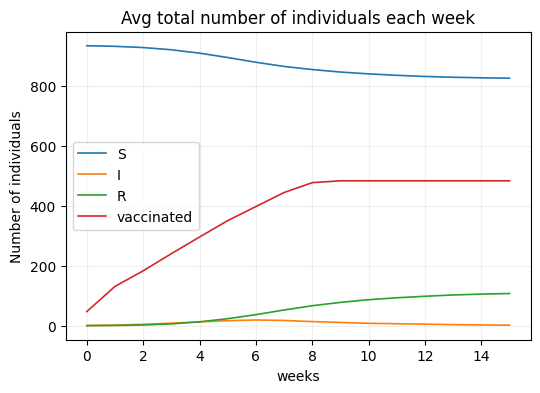

In [41]:
# plot results
fig, ax = plt.subplots(figsize=(6,4))
avg_population = []
avg_population.append(avg_S_per_week)
avg_population.append(avg_I_per_week)
avg_population.append(avg_R_per_week)
avg_population.append(avg_V_per_week)
lab = ["S","I","R","vaccinated"]
for i in range(len(avg_population)):
  plt.plot(np.arange(0,n_weeks + 1,1), avg_population[i],label=lab[i], linewidth=1.2)
plt.legend()
plt.title("Avg total number of individuals each week")
plt.xlabel("weeks")
plt.ylabel("Number of individuals")
plt.grid('minor', alpha=0.2)
fig.savefig('prob5_total_individuals.svg', format='svg', dpi=1200)
plt.show()

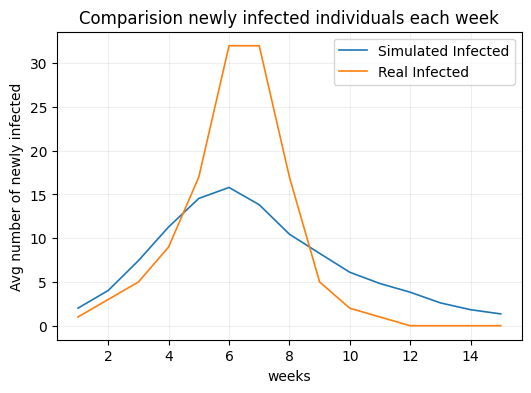

In [42]:
# plot results
fig, ax = plt.subplots(figsize=(6,4))
plt.plot(np.arange(1,n_weeks + 1,1), avg_newly_infected_per_week,label="Simulated Infected", linewidth=1.2)
plt.plot(np.arange(1,n_weeks + 1,1), sweden_infected_per_week,label="Real Infected", linewidth=1.2)
plt.legend()
plt.title("Comparision newly infected individuals each week")
plt.xlabel("weeks")
plt.ylabel("Avg number of newly infected")
plt.grid('minor', alpha=0.2)
fig.savefig('prob5_avg_infected.svg', format='svg', dpi=1200)
plt.show()